<a href="https://colab.research.google.com/github/Rosie-Brigham/colab-gists/blob/main/model_1s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip3 install tensorflow==1.14 #TODO - UPGRADE TO TF2!!!!!


     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 3.2MB 39.3MB/s 
     |████████████████████████████████| 491kB 47.0MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


Adapted Deeplab model (edit as approriate to move into 'datasets' directory)

# Adapted/copied from Deeplab demo code 

In [ ]:
!echo $PYTHONPATH

/env/python


In [ ]:
#@title Imports

import os
import io
import tarfile
import tempfile
import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # TODO - change everything here to tf2!!!

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [ ]:
#@title Helper methods

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(resize_ratio)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    print(target_size)
    #return resized_image, np.zeros(target_size)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')
  
  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 5, width_ratios=[6, 6, 6, 1, 6])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([],[])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray(['background', 'wall', 'building;edifice', 'sky', 'floor;flooring', 'tree', 'ceiling', 'road;route', 'bed', 'windowpane;window', 'grass', 'cabinet', 'sidewalk;pavement', 'person;individual;someone;somebody;mortal;soul', 'earth;ground', 'door;double;door', 'table', 'mountain;mount', 'plant;flora;plant;life', 'curtain;drape;drapery;mantle;pall', 'chair', 'car;auto;automobile;machine;motorcar', 'water', 'painting;picture', 'sofa;couch;lounge', 'shelf', 'house', 'sea', 'mirror', 'rug;carpet;carpeting', 'field', 'armchair', 'seat', 'fence;fencing', 'desk', 'rock;stone', 'wardrobe;closet;press', 'lamp', 'bathtub;bathing;tub;bath;tub', 'railing;rail', 'cushion', 'base;pedestal;stand', 'box', 'column;pillar', 'signboard;sign', 'chest;of;drawers;chest;bureau;dresser', 'counter', 'sand', 'sink', 'skyscraper', 'fireplace;hearth;open;fireplace', 'refrigerator;icebox', 'grandstand;covered;stand', 'path', 'stairs;steps', 'runway', 'case;display;case;showcase;vitrine', 'pool;table;billiard;table;snooker;table', 'pillow', 'screen;door;screen', 'stairway;staircase', 'river', 'bridge;span', 'bookcase', 'blind;screen', 'coffee;table;cocktail;table', 'toilet;can;commode;crapper;pot;potty;stool;throne', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove;kitchen;stove;range;kitchen;range;cooking;stove', 'palm;palm;tree', 'kitchen;island', 'computer;computing;machine;computing;device;data;processor;electronic;computer;information;processing;system', 'swivel;chair', 'boat', 'bar', 'arcade;machine', 'hovel;hut;hutch;shack;shanty', 'bus;autobus;coach;charabanc;double-decker;jitney;motorbus;motorcoach;omnibus;passenger;vehicle', 'towel', 'light;light;source', 'truck;motortruck', 'tower', 'chandelier;pendant;pendent', 'awning;sunshade;sunblind', 'streetlight;street;lamp', 'booth;cubicle;stall;kiosk', 'television;television;receiver;television;set;tv;tv;set;idiot;box;boob;tube;telly;goggle;box', 'airplane;aeroplane;plane', 'dirt;track', 'apparel;wearing;apparel;dress;clothes', 'pole', 'land;ground;soil', 'bannister;banister;balustrade;balusters;handrail', 'escalator;moving;staircase;moving;stairway', 'ottoman;pouf;pouffe;puff;hassock', 'bottle', 'buffet;counter;sideboard', 'poster;posting;placard;notice;bill;card', 'stage', 'van', 'ship', 'fountain', 'conveyer;belt;conveyor;belt;conveyer;conveyor;transporter', 'canopy', 'washer;automatic;washer;washing;machine', 'plaything;toy', 'swimming;pool;swimming;bath;natatorium', 'stool', 'barrel;cask', 'basket;handbasket', 'waterfall;falls', 'tent;collapsible;shelter', 'bag', 'minibike;motorbike', 'cradle', 'oven', 'ball', 'food;solid;food', 'step;stair', 'tank;storage;tank', 'trade;name;brand;name;brand;marque', 'microwave;microwave;oven', 'pot;flowerpot', 'animal;animate;being;beast;brute;creature;fauna', 'bicycle;bike;wheel;cycle', 'lake', 'dishwasher;dish;washer;dishwashing;machine', 'screen;silver;screen;projection;screen', 'blanket;cover', 'sculpture', 'hood;exhaust;hood', 'sconce', 'vase', 'traffic;light;traffic;signal;stoplight', 'tray', 'ashcan;trash;can;garbage;can;wastebin;ash;bin;ash-bin;ashbin;dustbin;trash;barrel;trash;bin', 'fan', 'pier;wharf;wharfage;dock', 'crt;screen', 'plate', 'monitor;monitoring;device', 'bulletin;board;notice;board', 'shower', 'radiator', 'glass;drinking;glass', 'clock', 'flag'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


In [ ]:
def draw_image(im):
  plt.imshow(im)

# Load the Model

In [ ]:
!wget -O deeplabv3_xception_ade20k_train_2018_05_29.tar.gz http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz

--2021-01-27 11:18:24--  http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460299576 (439M) [application/x-tar]
Saving to: ‘deeplabv3_xception_ade20k_train_2018_05_29.tar.gz’

deeplabv3_xception_ 100%[===================>] 438.98M   102MB/s    in 4.3s    

2021-01-27 11:18:28 (102 MB/s) - ‘deeplabv3_xception_ade20k_train_2018_05_29.tar.gz’ saved [460299576/460299576]



In [ ]:
# _TARBALL_NAME = 'trained_model.tar.gz' # adapted model - TODO - this is where the retrained model should go
_TARBALL_NAME = 'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz' #using ade20k as demo

import os
print(os.getcwd())



/content


In [ ]:
MODEL = DeepLabModel(_TARBALL_NAME)
print('model loaded successfully!')

model loaded successfully!


In [ ]:
# !pip3 install requests
# from urllib.request import urlopen -- needed?


# Start playing with model


running deeplab on image ...
0.8015625
(513, 384)


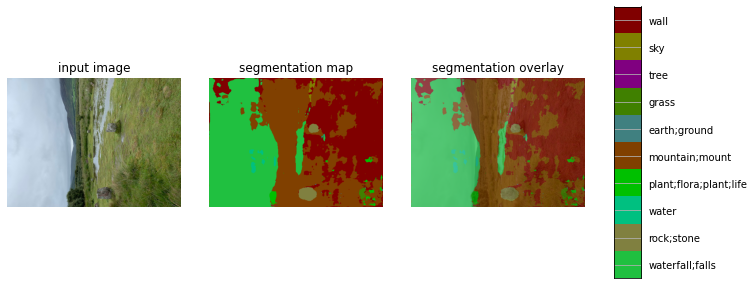

In [ ]:
from os import path, getcwd
import requests
from io import BytesIO

demo_image = 'http://monument-monitor.herokuapp.com/rails/active_storage/blobs/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBZ1laIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--6920b4fed67ded2618cd59fb16724fc67023e8c2/IMG_3043.jpg'
response = requests.get(demo_image)
img = Image.open(BytesIO(response.content))


print('running deeplab on image ...')
resized_im, seg_map = MODEL.run(img)
vis_segmentation(resized_im, seg_map)


In [ ]:
seg_image = label_to_color_image(seg_map).astype(np.uint8)
# plt.imshow(seg_image)
specific_label = np.where(LABEL_NAMES == 'water')[0][0]
rgb = FULL_COLOR_MAP[specific_label][0]
number = np.sum(np.all(seg_image == rgb, axis=2))

print("water RGB value:")
print(rgb)

print("number of pixels that are considered water:")
print(number)

water RGB value:
[  0 192 128]
number of pixels that are considered water:
1087


# **Get pixel data on water**

In [ ]:
#@title pixel data helper methods
def get_pixel_count(label, seg_image):
  segmentation_map = label_to_color_image(seg_image).astype(np.uint8)

  # Gets index for specific label
  specific_label = np.where(LABEL_NAMES == label)[0][0]

  # Gets RGB value for specific label
  rgb = FULL_COLOR_MAP[specific_label][0]

  # Count number of pixels in image with that RGB value  
  number = np.sum(np.all(segmentation_map == rgb, axis=2))
  return number

# pixel_count = seg_image.size
# print("Amount of pixels in image is " + str(pixel_count) )

def get_relative_pixel_count(label, seg_image):
  pixels = get_pixel_count(label, seg_image)
  img = Image.fromarray(seg_image, 'RGB')
  width, height = img.size
  totalPixels = width * height
  percentagePixels = (pixels / totalPixels) * 100
  print("pixels " + str(pixels))
  print("relative pixels " + str(percentagePixels))
  return percentagePixels
  



# Iterate through CSV

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv 
import pandas as pd
import urllib
from urllib.request import urlopen

BASE_URL = "https://monument-monitor.herokuapp.com"

# function to get relative pixel count
def relative_pixel_count(row):
  # get the image
  img_url = BASE_URL + row['url']
  img = Image.open(urlopen(img_url))
  print('running model on image' + row['date'])
  resized_im, seg_map = MODEL.run(img)
  vis_segmentation(resized_im, seg_map)

  relative_pixels = get_relative_pixel_count('water', seg_map)

  return relative_pixels

In [ ]:
## function to get the numeral amount of the flooding

def quantify_observed_rainfall(row):
  if row['tag'] == 'none':
    val = 0
  elif row['tag'] == 'minimal':
    val = 1
  elif row['tag'] == 'some':
    val = 1
  elif row['tag'] == 'a lot':
    val = 2
  elif row['tag'] == 'substantial':
    val = 3
  elif row['tag'] == 'extensive':
    val = 4
  else:
    return 
  return val


In [ ]:
# !pip install urllib
# import urllib.request

# CSV file of circle 6, with waterlevel tags
csv = 'https://monument-monitor-reports.s3.eu-west-2.amazonaws.com/tag-report-circle+6-2021-01-07.csv'

## get csv file
data = pd.read_csv(csv)
print(data.head())
## create new data structure
submitted = data[['submission-id','date','url','tag']]

# add amount to df
submitted['amount'] = submitted.apply(quantify_observed_rainfall, axis=1)

#add relative pixel to df
# submitted['relative_pixel'] = submitted.apply(relative_pixel_count, axis=1)

   submission-id  ...      tag
0           1616  ...  minimal
1           1617  ...    a lot
2           1928  ...     none
3           1929  ...     none
4           1936  ...     none

[5 rows x 4 columns]


print(submitted)


In [ ]:
#@title splurge out the df with the relative pixel count of water
# Take this cv, and make beautiful plots...
pd.set_option('display.max_rows', 500)
print(submitted.to_csv())


,submission-id,date,url,tag,amount
0,1616,23/04/2018,/rails/active_storage/blobs/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaVVHIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--8d9f63a46f17f7a7807d215ff67262d4088b71a5/1616_23-04-2018_e.jpg,minimal,1
1,1617,23/04/2018,/rails/active_storage/blobs/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaVlHIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--55d9f7a2eae42ce2c488d0369e87655f2c4b07fd/1617_23-04-2018_e.jpg,a lot,2
2,1928,26/05/2018,/rails/active_storage/blobs/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbUFIIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--e8381e6fa12b75a8a3b00749fd12abfe774a7081/1928_26-05-2018_t.jpg,none,0
3,1929,25/05/2018,/rails/active_storage/blobs/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbUVIIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--81de62c8db6709db0787975909a6aec5f110f8f2/1929_25-05-2018_t.jpg,none,0
4,1936,18/05/2018,/rails/active_storage/blobs/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbWdIIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--6dc54ad412a7ed92e246ba3681d4f754957cb86b/

In [ ]:
print(data.head())

   submission-id  ...      tag
0           1616  ...  minimal
1           1617  ...    a lot
2           1928  ...     none
3           1929  ...     none
4           1936  ...     none

[5 rows x 4 columns]


Getting data with validation set

In [ ]:
!git clone https://github.com/monumentalconservation/training_data.git
%ls training_data/

Cloning into 'training_data'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 483 (delta 28), reused 71 (delta 24), pack-reused 406
Receiving objects: 100% (483/483), 60.54 MiB | 49.55 MiB/s, done.
Resolving deltas: 100% (57/57), done.
images/   masks/                  save-images.py   val_images/
ims.json  save-images-no-dups.py  validation.json  val_masks/


In [ ]:
img = Image.open('/content/training_data/val_images/10.jpeg')

resized_im, seg_map = MODEL.run(img)
plt.imshow(seg_map)
seg_image = label_to_color_image(seg_map).astype(np.uint8)
plt.imshow(seg_image)

0.12427325581395349
(513, 288)


In [ ]:
# All together now...
image_path = '/content/training_data/val_images/10.jpeg'
mask_path = '/content/training_data/val_masks/10.png'
from sklearn.metrics import confusion_matrix


def get_stats(row):
    # PREDICTED
    # Get the image
    img = Image.open('training_data/val_images/' + row['Image'])
    # Run model on image
    resized_im, seg_map = MODEL.run(img)
    # Get the coloured segmentation map
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    # make a copy of this image (which you need to do to apply transformations)
    seg_copy = seg_image.copy()
    # create a mask of only the water pixels
    water_pixels_mask = np.all(seg_copy == [0, 192, 128], axis=-1)
    non_water_pixels_mask = np.any(seg_copy != [0, 192, 128], axis=-1)  

    # apply this to image, so its just a mask of the images
    seg_copy[water_pixels_mask] = [255, 255, 255]
    seg_copy[non_water_pixels_mask] = [0, 0, 0]

    # transform the image into a PIL image, in order to change the mode
    img = Image.fromarray(seg_copy.astype('uint8')).resize((400,400))
    img = img.convert('1')

    # transform back to ndim array, in order to re-shape
    predicted_mask =  np.array(img).astype(np.uint8).reshape(-1,1)


    # GROUND TRUTH
    # get the ground truth
    val_mask = Image.open('training_data/val_masks/' + row['Mask'])
    # resize, convert mode, turn into d.dim array and re-shape
    ground_truth = np.array(val_mask.resize((400,400)).convert('1')).astype(np.uint8).reshape(-1,1)

    # CONFUSION MATRIX
    confusionMatrix = pd.DataFrame(confusion_matrix(ground_truth,predicted_mask),columns = ['Background','Water'],index = ['Background','Water'])

    recall_of_prediction = confusionMatrix.at['Water', 'Water'] / (confusionMatrix.at['Water', 'Water'] + confusionMatrix.at['Water', 'Background'])
    precision = confusionMatrix.at['Water', 'Water'] / (confusionMatrix.at['Water', 'Water'] + confusionMatrix.at['Background', 'Water'])
    intersection_over_union = confusionMatrix.at['Water', 'Water'] / (confusionMatrix.at['Water', 'Water'] + confusionMatrix.at['Background', 'Water'] + confusionMatrix.at['Water', 'Background'])

    recall_of_prediction = round(recall_of_prediction,2) *100
    precision = round(precision,2) *100
    intersection_over_union = round(intersection_over_union,2)

    return [recall_of_prediction, precision, intersection_over_union]

In [ ]:
images = os.listdir('training_data/val_images')
masks = os.listdir('training_data/val_masks')
images.sort()
masks.sort()

data = { "Image": images, "Mask": masks }
images = pd.DataFrame(data)

In [ ]:
import torch
model = MODEL
device = torch.device("cuda:0")

images['stats'] = images.apply(get_stats, axis=1)
images[['recall','precision','IoU']] = pd.DataFrame(images.stats.tolist(), index= images.index)
images = images.drop(['stats'], axis=1)
images

0.11094290657439447
(513, 384)
0.12427325581395349
(513, 288)
0.12723214285714285
(513, 384)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


0.320625
(513, 288)
0.4275
(513, 384)
0.4275
(384, 513)
0.320625
(513, 384)
0.320625
(384, 513)
0.320625
(513, 249)
0.12723214285714285
(384, 513)
0.32082551594746717
(513, 384)
0.320625
(513, 384)
0.4275
(384, 513)
0.4275
(513, 384)
0.4275
(513, 384)
0.320625
(384, 513)
0.32082551594746717
(513, 384)
0.125244140625
(513, 384)
0.320625
(513, 384)
0.12723214285714285
(513, 384)
0.4275
(513, 384)
0.5009765625
(513, 384)
0.320625
(384, 513)
0.320625
(513, 384)
0.8015625
(513, 384)


,Image,Mask,recall,precision,IoU
0,1.jpeg,1.png,2.0,0.0,0.00
1,10.jpeg,10.png,68.0,56.0,0.44
2,11.jpeg,11.png,0.0,NaN,0.00
3,12.jpeg,12.png,0.0,0.0,0.00
4,13.jpeg,13.png,74.0,41.0,0.36
5,14.jpeg,14.png,68.0,20.0,0.19
6,15.jpeg,15.png,0.0,NaN,0.00
7,16.jpeg,16.png,0.0,NaN,0.00
8,17.jpeg,17.png,89.0,56.0,0.52
9,18.jpeg,18.png,0.0,NaN,0.00
